<a href="https://colab.research.google.com/github/azkbrqlna/2025-ComputerVision/blob/main/Jobsheet3_RegresiGambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum D1 - Prediksi Radius Lingkaran

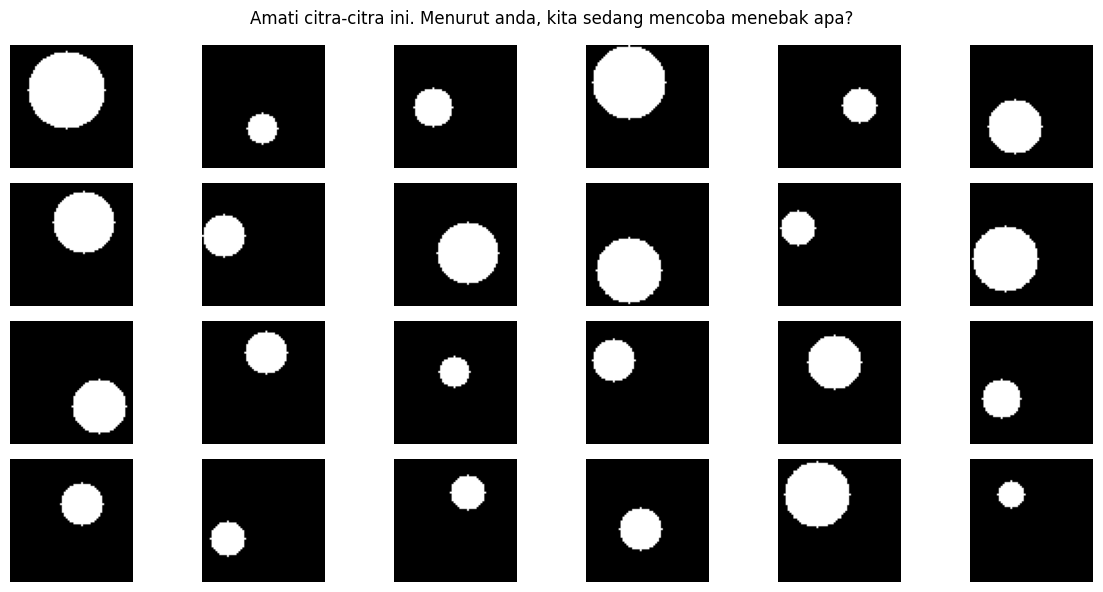

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models


def make_sample(img_size=64, min_r = 5, max_r=20):
  r = np.random.randint(min_r, max_r + 1) # radius acak
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r) # center-x
  cy = np.random.randint(r, img_size - r) #center-y
  cv2.circle(img, (cx, cy), int(r), (255,), -1)
  img = (img / 255.0).astype(np.float32)
  # 3 channel biar kompatibel CNN
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)



N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

cols = 6
rows = N_show // cols
plt.figure(figsize=(12,6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()




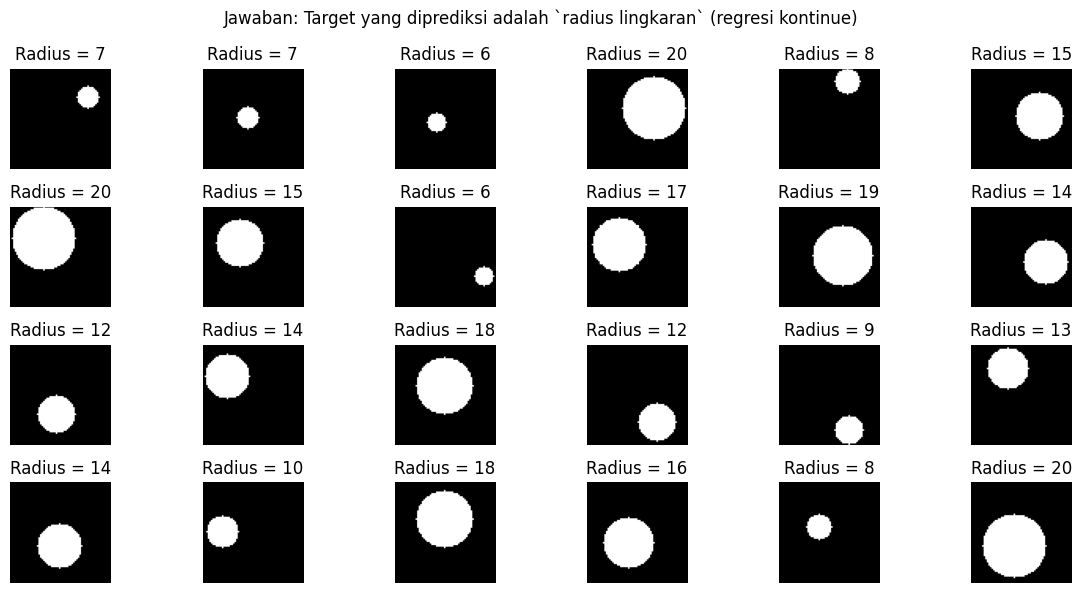

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.title(f"Radius = {int(rads[i])}")
  plt.axis('off')

plt.suptitle("Jawaban: Target yang diprediksi adalah `radius lingkaran` (regresi kontinue)")
plt.tight_layout()
plt.show()

In [ ]:
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
epochs=12, batch_size=64, verbose=0)

y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


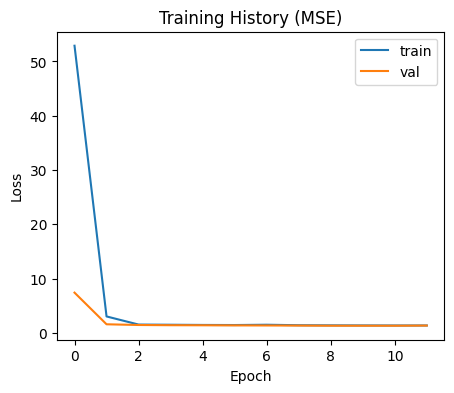

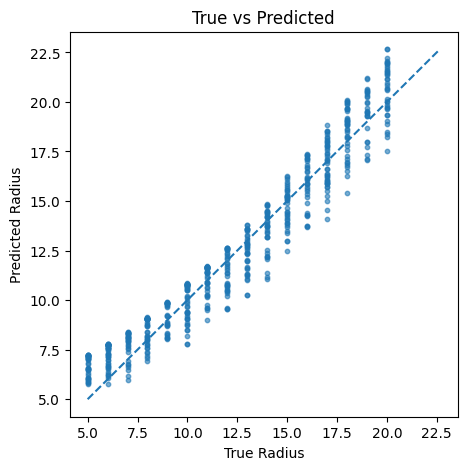

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("True vs Predicted")
plt.show()

## Praktikum D2 - Menebak Umur Manusia dari Foto Wajah (UTKFace)

In [ ]:
from google.colab import files
files.upload() # pilih kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"azkabariqlana","key":"91e048f00028be3d94996f30f8d635bb"}'}

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("Kaggle API siap digunakan")
else:
  print("Kaggle API tidak ditemukan")

Kaggle API siap digunakan


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("Dataset UTKFace berhasil diekstrak")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
Dataset UTKFace berhasil diekstrak


Total gambar ditemukan: 23708


<function matplotlib.pyplot.show(close=None, block=None)>

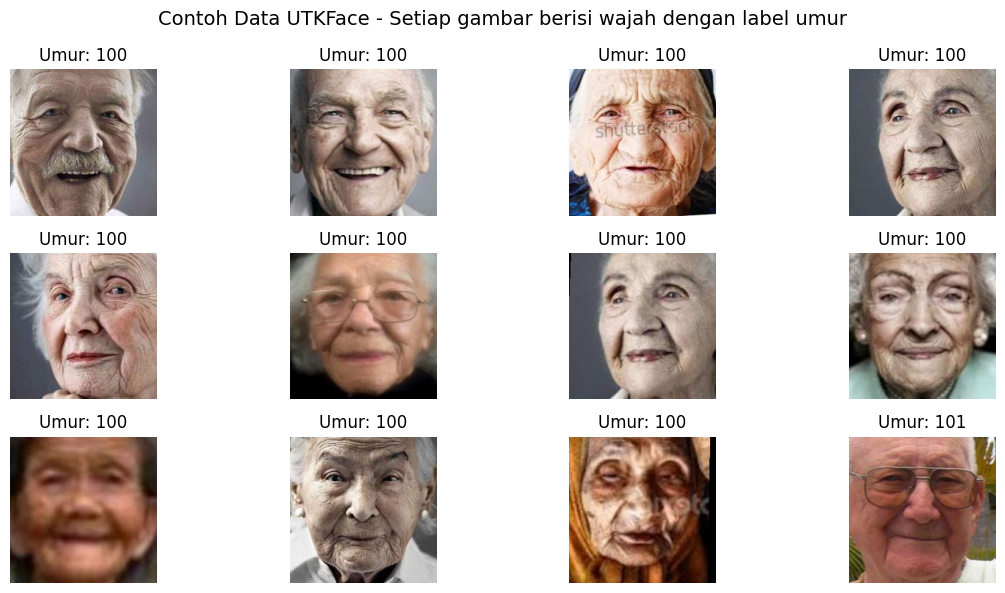

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3, 4, i+1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis("off")

plt.suptitle("Contoh Data UTKFace - Setiap gambar berisi wajah dengan label umur", fontsize=14)
plt.tight_layout()
plt.show

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)
IMG_SIZE = 160

def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files,
y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files,
y_test)).map(load_img).batch(64)
print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")
IMG_SIZE = 160

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse', metrics=['mae'])
model.summary()


Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 57s 124ms/step - loss: 367.1501 - mae: 14.0673 - val_loss: 160.7973 - val_mae: 9.6948 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 156.5539 - mae: 9.3457 - val_loss: 146.8632 - val_mae: 9.1152 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 144.2125 - mae: 8.8929 - val_loss: 140.8533 - val_mae: 8.8127 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - loss: 141.9967 - mae: 8.7807 - val_loss: 138.9798 - val_mae: 8.7714 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 138.7998 - mae: 8.6662 - val_loss: 137.7672 - val_mae: 8.7254 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - loss: 135.6773 - mae: 8.5756 - val_loss: 136.8258 - val_mae: 8.6724 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 133.8812 - mae: 8.4700 - val_loss: 134.7437 - va

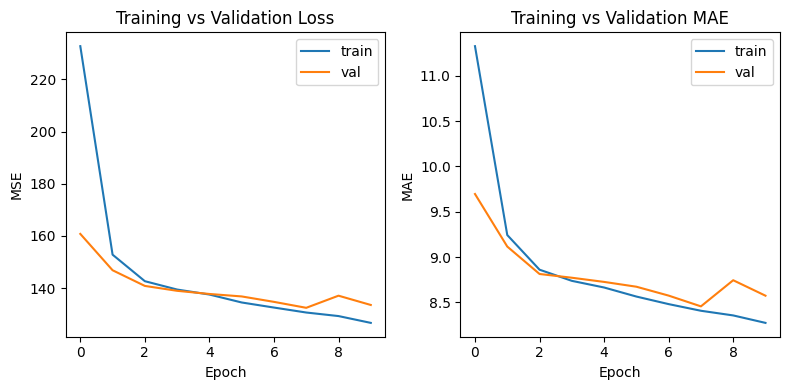

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - loss: 128.3154 - mae: 8.3035 - val_loss: 131.2068 - val_mae: 8.3449 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 126.3710 - mae: 8.2609 - val_loss: 131.4971 - val_mae: 8.3954 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 127.8588 - mae: 8.3103 - val_loss: 131.0481 - val_mae: 8.3592 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 126.9052 - mae: 8.2490 - val_loss: 130.8216 - val_mae: 8.3322 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 125.9528 - mae: 8.2358 - val_loss: 130.6643 - val_mae: 8.3153 - learning_rate: 1.0000e-04


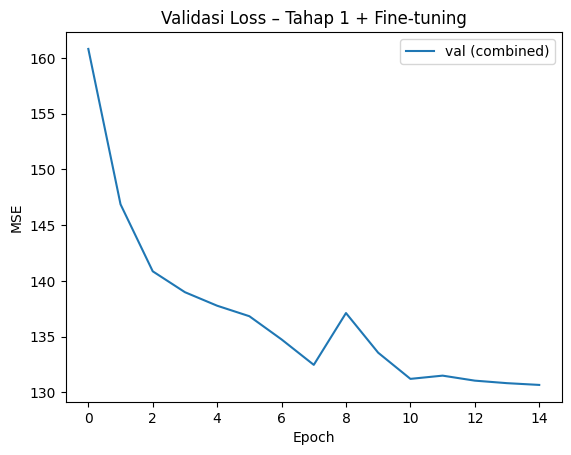

In [ ]:
for layer in base_model.layers[:-30]:
  layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

MAE: 8.32 tahun
RMSE: 11.43 tahun
R²: 0.671


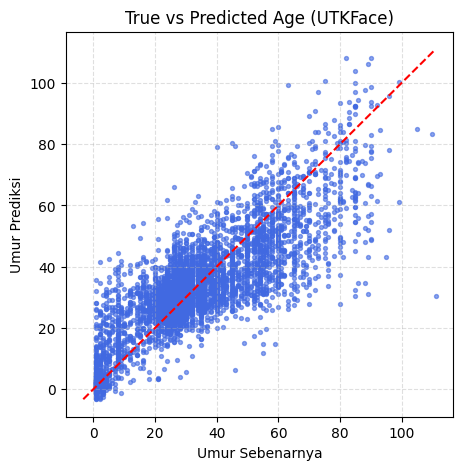

In [ ]:
from math import sqrt
y_pred = np.concatenate([model.predict(batch[0], verbose=0). ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} tahun")
print(f"RMSE: {rmse:.2f} tahun")
print(f"R²: {r2:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color="royalblue")
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya"); plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

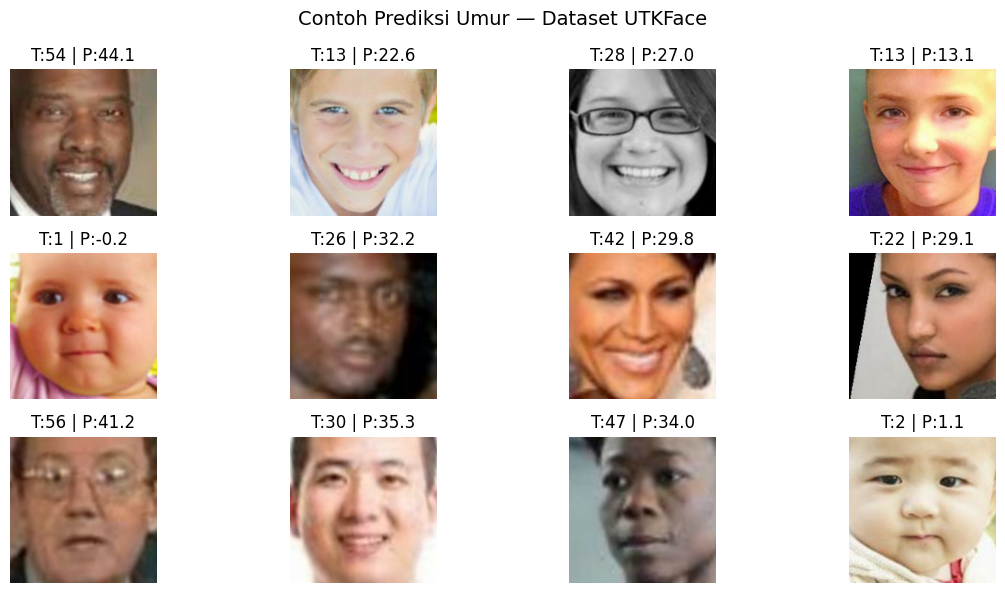

In [ ]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age} | P:{pred_age:.1f}")
  plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

## Praktikum D3 - Menilai “Kepopuleran Hewan Peliharaan” dari Foto

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"azkabariqlana","key":"91e048f00028be3d94996f30f8d635bb"}'}

In [2]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("Kaggle API siap digunakan")
else:
  print("Kaggle API tidak ditemukan")

Kaggle API siap digunakan


In [4]:
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("Dataset Pawpularity berhasil dieksrak")

Dataset Pawpularity berhasil dieksrak


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

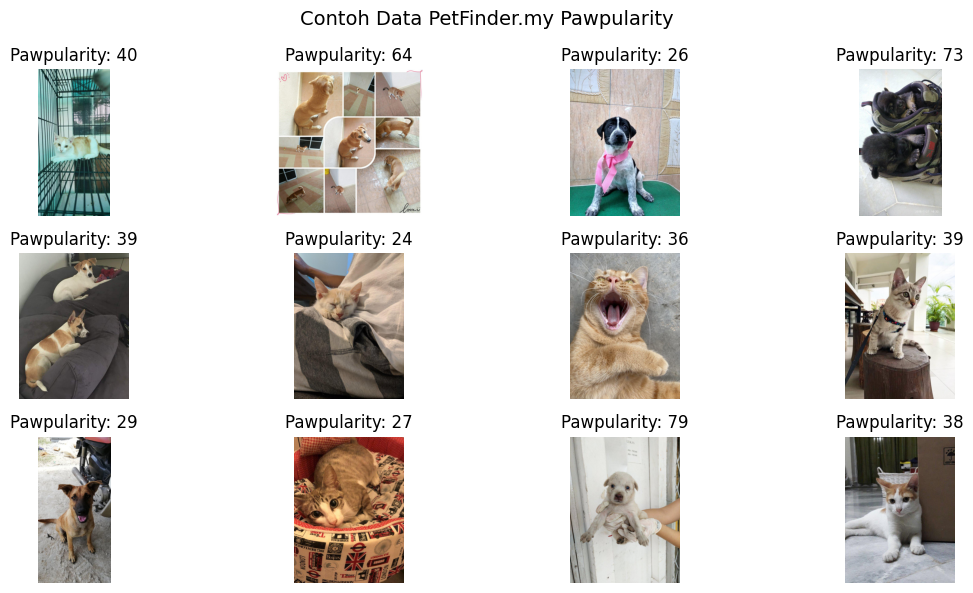

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# muat csv
df = pd.read_csv("/content/paw/train.csv")
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

plt.figure(figsize=(12,6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3,4,i+1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis("off")

plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = tf.cast(img, tf.float32) / 255.0
  return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'],
train_df['Pawpularity']))\
  .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
  .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'],
val_df['Pawpularity']))\
  .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
  .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset Siap Digunakan - {len(train_df)} untuk training, {len(val_df)} untuk validasi")

Dataset Siap Digunakan - 7929 untuk training, 1983 untuk validasi


In [15]:
from tensorflow.keras import layers, models
import tensorflow as tf

IMG_SIZE = 224

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
import tensorflow as tf

cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 127s 765ms/step - loss: 823.5956 - mae: 21.6973 - val_loss: 479.6709 - val_mae: 16.1038 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 195ms/step - loss: 419.9131 - mae: 15.1586 - val_loss: 433.0160 - val_mae: 15.4725 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - loss: 401.2192 - mae: 14.8679 - val_loss: 409.2054 - val_mae: 14.6732 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 193ms/step - loss: 361.4887 - mae: 14.1226 - val_loss: 394.8209 - val_mae: 14.7031 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 230ms/step - loss: 364.6765 - mae: 14.1625 - val_loss: 383.7601 - val_mae: 14.4905 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 82s 236ms/step - loss: 351.5731 - mae: 13.9093 - val_loss: 376.8401 - val_mae: 14.2427 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 212ms/step - loss: 332.4239 - mae: 13.5625 - val_

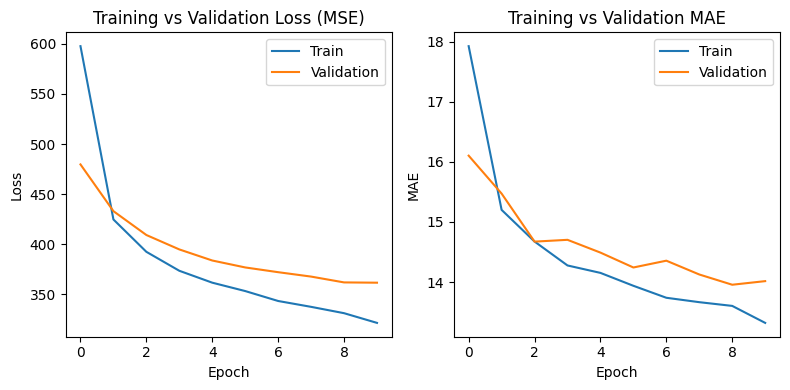

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()


MAE = 14.02
RMSE = 19.02
R²  = 0.182


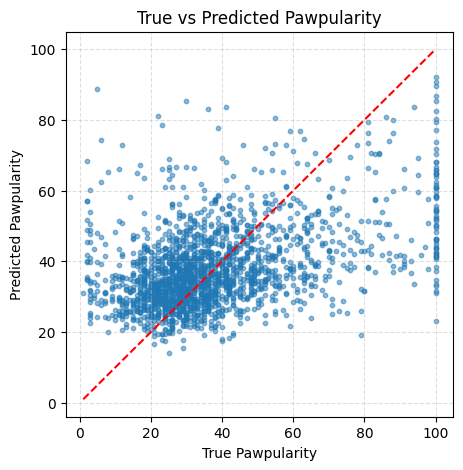

In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²  = {r2:.3f}")

plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

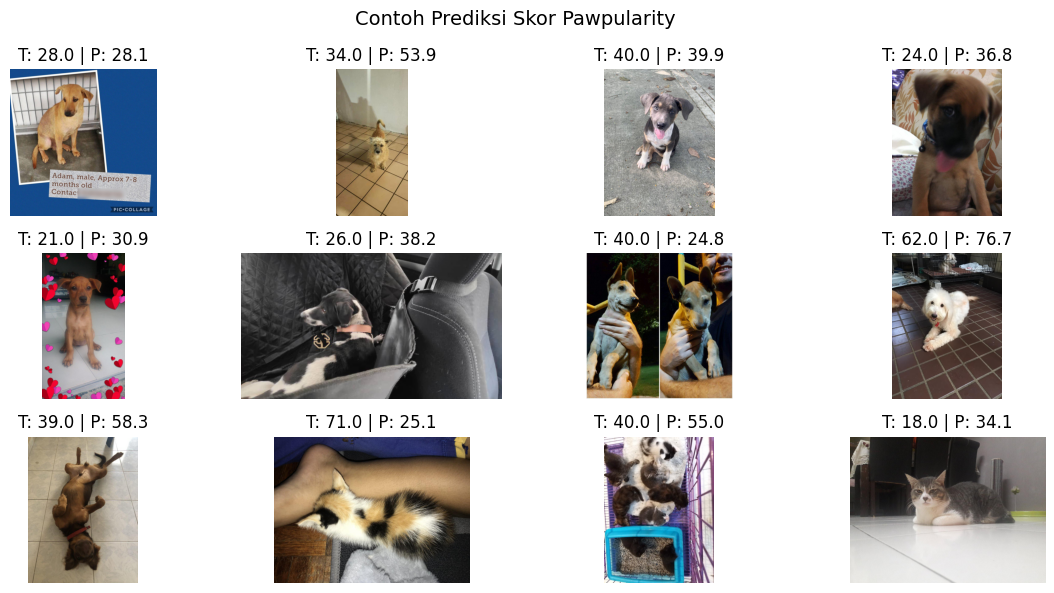

In [19]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_rows.itertuples()):
  img = Image.open(row.path)
  pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"T: {row.Pawpularity:.1f} | P: {pred:.1f}")
  plt.axis('off')

plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()


## Penugasan

### 1. Prediksi usia

Saving fotoku.jpg to fotoku (6).jpg


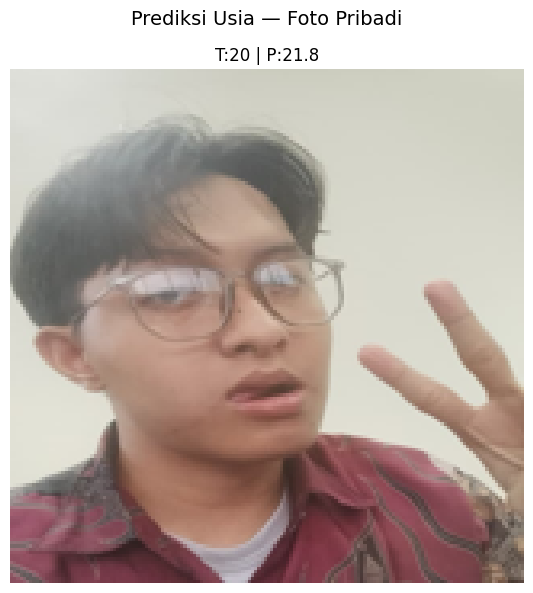

Mean Absolute Error (MAE): 1.78 tahun


In [30]:
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

IMG_SIZE = 160
uploaded = files.upload()

true_ages = []
pred_ages = []

umur_asli = 20

plt.figure(figsize=(12, 6))

for i, (fname, filedata) in enumerate(uploaded.items()):
    img = Image.open(fname).convert('RGB')
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0

    pred_age = model.predict(tf.expand_dims(img_array, 0), verbose=0).ravel()[0]

    true_ages.append(umur_asli)
    pred_ages.append(pred_age)

    plt.subplot(1, len(uploaded), i+1)
    plt.imshow(img)
    plt.title(f"T:{umur_asli} | P:{pred_age:.1f}")
    plt.axis('off')

plt.suptitle("Prediksi Usia — Foto Pribadi", fontsize=14)
plt.tight_layout()
plt.show()

# Hitung akurasi (MAE)
mae = np.mean(np.abs(np.array(true_ages) - np.array(pred_ages)))
print(f"Mean Absolute Error (MAE): {mae:.2f} tahun")


### 2. Prediksi Uji model Pawpularity

Saving kucing.jpg to kucing (11).jpg


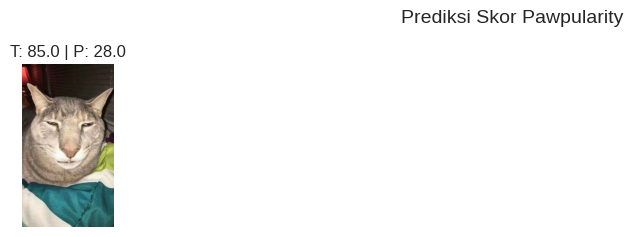

In [40]:
from google.colab import files

uploaded = files.upload()

IMG_SIZE = 224
upload_list = []

nilai_asli = 85

for fname in uploaded.keys():
    upload_list.append({'path': fname, 'Pawpularity': nilai_asli})

upload_df = pd.DataFrame(upload_list)

# Plot hasil prediksi
plt.figure(figsize=(12, 6))
for i, row in enumerate(upload_df.itertuples()):
    img = Image.open(row.path).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_resized) / 255.0

    pred = model.predict(tf.expand_dims(img_array, 0), verbose=0).ravel()[0]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"T: {row.Pawpularity:.1f} | P: {pred:.1f}")
    plt.axis('off')

plt.suptitle("Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()
